# Imports

In [54]:
import sys
sys.path.append('..')

In [55]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import alignment.alignment_utils as utils

%matplotlib inline

# Data Loading

### Real data

In [56]:
DATA_PATH = '../data/'
data_filename = DATA_PATH + 'pt_decoding_data_S62.pkl'
# data_filename = DATA_PATH + 'pt_decoding_data_S22_zscore.pkl'

In [57]:
all_pt_dict = utils.load_pkl(data_filename)
pt_names = list(all_pt_dict.keys())

In [58]:
print(pt_names)
print(all_pt_dict[pt_names[0]].keys())
print([all_pt_dict[pt]['X1'].shape for pt in pt_names])

['S14', 'S26', 'S23', 'S33', 'S22', 'S39', 'S58', 'S62']
dict_keys(['ID', 'X1', 'X1_map', 'y1', 'X2', 'X2_map', 'y2', 'X3', 'X3_map', 'y3', 'y_full_phon', 'X_collapsed', 'y_phon_collapsed', 'y_artic_collapsed', 'pre_pts'])
[(144, 200, 111), (148, 200, 111), (151, 200, 63), (46, 200, 149), (151, 200, 74), (137, 200, 144), (141, 200, 171), (178, 200, 201)]


In [79]:
all_pt_chan_data = {}
for pt in pt_names:
    temp = {}
    temp['map'] = sio.loadmat(DATA_PATH + f'{pt}/{pt}_channelMap.mat'.format(pt))['chanMap']
    if pt == 'S58':
        temp['sig'] = sio.loadmat(DATA_PATH + f'{pt}/{pt}_sigChannel.mat'.format(pt))['sigChannel'] - 2 # this is so weird
    else:
        temp['sig'] = sio.loadmat(DATA_PATH + f'{pt}/{pt}_sigChannel.mat'.format(pt))['sigChannel'] - 1
    all_pt_chan_data[pt] = temp

### Surrogate TME Data

In [60]:
# surr_types = ['T', 'N', 'C', 'TN', 'TC', 'NC', 'TNC']
# surr_types = ['N', 'C', 'NC']  # no T
# surr_types = ['T', 'C', 'TC']  # no N
# surr_types = ['T', 'N', 'TN'] # no C
surr_types = ['TNC']
# surr_types = ['TNC', 'T', 'TN']
surr_suffix = ''
# surr_suffix = '_zscore'


all_pt_surr_dict = {}
# for pt in pt_names:
#     all_surr_dict = {}
#     for surr in surr_types:
#         surr_data = sio.loadmat(f'../data/{pt}/TME/{pt}_TME_{surr}{surr_suffix}.mat')['surrTensor']
#         all_surr_dict[surr] = surr_data
#     all_pt_surr_dict[pt] = all_surr_dict


# print(all_pt_surr_dict.keys())
# print(all_pt_surr_dict['S14'].keys())
# print([all_pt_surr_dict[pt][surr].shape for pt in pt_names])

## Phoneme label processing functions

In [61]:
phon_labels = np.array(['a', 'ae', 'i', 'u', 'b', 'p', 'v', 'g', 'k'])
artic_labels = np.array(['low', 'high', 'labial', 'dorsal'])
phon_to_artic_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4}

In [62]:
def phon_to_artic(phon_idx, phon_to_artic_conv):
    return phon_to_artic_conv[phon_idx]

def phon_to_artic_seq(phon_seq, phon_to_artic_conv):
    flat_seq = phon_seq.flatten()
    artic_conv = np.array([phon_to_artic(phon_idx, phon_to_artic_conv) for phon_idx in flat_seq])
    return np.reshape(artic_conv, phon_seq.shape)

def phon2artic(phon):
    return artic_labels[phon_to_artic_dict[int(phon)] - 1]

def phon2artic_seq(phon_seq):
    return '_'.join([phon2artic(phon) for phon in phon_seq])

def labels2cv_seq(labels):
    labels_str = []
    for lab in labels:
        labels_str.append(labels2cv(lab))
    return np.array(labels_str)

def labels2cv(str):
    middle_val = str[1]
    if int(middle_val) < 5:
        return 'CVC'
    else:
        return 'VCV'

def articic_nums2seq(artic_num_seqs):
    return np.array([artic_labels[artic_num-1] for artic_num in artic_num_seqs])

## Data Processing

In [63]:
p_ind = 1

all_pt_traces = {}
all_pt_surr_traces = {}
all_pt_phon_labels = {}
all_pt_phon_seqs = {}
all_pt_phon_seqs_str = {}
all_pt_artic_labels = {}
all_pt_artic_seqs = {}
all_pt_artic_seqs_str = {}
all_pt_cv_labels = {}
for pt in pt_names:
    pt_trace = all_pt_dict[pt][f'X{p_ind}']  ### Real data: (trials, time, channels)

    # surr_type_traces = {}
    # for surr in surr_types:
    #     surr_type_traces[surr] = np.transpose(all_pt_surr_dict[pt][surr], [2,0,1])  ### Surrogate data: (time, channels, trials) -> (trials, time, channels)

    pt_phon_labels = all_pt_dict[pt][f'y{p_ind}']
    pt_phon_seqs = all_pt_dict[pt]['y_full_phon']
    pt_phon_seqs_str = utils.label_seq2str(pt_phon_seqs)
    pt_artic_labels = phon_to_artic_seq(pt_phon_labels, phon_to_artic_dict)
    pt_artic_seqs = phon_to_artic_seq(pt_phon_seqs, phon_to_artic_dict)
    pt_artic_seqs_str = utils.label_seq2str(pt_artic_seqs)
    pt_cv_labels = labels2cv_seq(pt_phon_seqs)

    all_pt_traces[pt] = pt_trace
    # all_pt_surr_traces[pt] = surr_type_traces
    all_pt_phon_labels[pt] = pt_phon_labels
    all_pt_phon_seqs[pt] = pt_phon_seqs
    all_pt_phon_seqs_str[pt] = pt_phon_seqs_str
    all_pt_artic_labels[pt] = pt_artic_labels
    all_pt_artic_seqs[pt] = pt_artic_seqs
    all_pt_artic_seqs_str[pt] = pt_artic_seqs_str
    all_pt_cv_labels[pt] = pt_cv_labels

In [64]:
# [all_pt_surr_traces[pt][list(all_pt_surr_traces[pt].keys())[0]].shape for pt in pt_names]

In [65]:
# artic_seq_strs = articic_nums2seq(pt_artic_seqs)
# artic_seq_strs = np.array([[s[0:2] + '_' for s in labs] for labs in artic_seq_strs])
# artic_seq_strs = utils.label2str(artic_seq_strs)
# artic_seq_strs = np.array([s[0:-1] for s in artic_seq_strs])

In [66]:
t = np.linspace(-0.5, 0.5 - 1/pt_trace.shape[1], pt_trace.shape[1])

In [67]:
# all_pt_phon_seq_avg_traces = {}
# all_pt_artic_seq_avg_traces = {}
# all_pt_phon_avg_traces = {}
# all_pt_artic_avg_traces = {}
# all_pt_cv_avg_traces = {}

# for pt in pt_names:
#     pt_trace = all_pt_traces[pt]
#     pt_phon_seqs_str = all_pt_phon_seqs_str[pt]
#     pt_artic_seqs_str = all_pt_artic_seqs_str[pt]
#     pt_phon_labels = all_pt_phon_labels[pt]
#     pt_artic_labels = all_pt_artic_labels[pt]
#     pt_cv_labels = all_pt_cv_labels[pt]

#     phon_seq_avg_trace = utils.cnd_avg(pt_trace, pt_phon_seqs_str)
#     artic_seq_avg_trace = utils.cnd_avg(pt_trace, pt_artic_seqs_str)
#     phon_avg_trace = utils.cnd_avg(pt_trace, pt_phon_labels)
#     artic_avg_trace = utils.cnd_avg(pt_trace, pt_artic_labels)
#     cv_avg_trace = utils.cnd_avg(pt_trace, pt_cv_labels)

#     all_pt_phon_seq_avg_traces[pt] = phon_seq_avg_trace
#     all_pt_artic_seq_avg_traces[pt] = artic_seq_avg_trace
#     all_pt_phon_avg_traces[pt] = phon_avg_trace
#     all_pt_artic_avg_traces[pt] = artic_avg_trace
#     all_pt_cv_avg_traces[pt] = cv_avg_trace

# Data Visualization

### Plotting utils

In [14]:
def line(error_y_mode=None, **kwargs):
    """Extension of `plotly.express.line` to use error bands.
    
    From https://stackoverflow.com/questions/69587547/continuous-error-band-with-plotly-express-in-python, user171780"""
    ERROR_MODES = {'bar','band','bars','bands',None}
    if error_y_mode not in ERROR_MODES:
        raise ValueError(f"'error_y_mode' must be one of {ERROR_MODES}, received {repr(error_y_mode)}.")
    if error_y_mode in {'bar','bars',None}:
        fig = px.line(**kwargs)
    elif error_y_mode in {'band','bands'}:
        if 'error_y' not in kwargs:
            raise ValueError(f"If you provide argument 'error_y_mode' you must also provide 'error_y'.")
        figure_with_error_bars = px.line(**kwargs)
        fig = px.line(**{arg: val for arg,val in kwargs.items() if arg != 'error_y'})
        for data in figure_with_error_bars.data:
            x = list(data['x'])
            y_upper = list(data['y'] + data['error_y']['array'])
            y_lower = list(data['y'] - data['error_y']['array'] if data['error_y']['arrayminus'] is None else data['y'] - data['error_y']['arrayminus'])
            color = f"rgba({tuple(int(data['line']['color'].lstrip('#')[i:i+2], 16) for i in (0, 2, 4))},.3)".replace('((','(').replace('),',',').replace(' ','')
            fig.add_trace(
                go.Scatter(
                    x = x+x[::-1],
                    y = y_upper+y_lower[::-1],
                    fill = 'toself',
                    fillcolor = color,
                    line = dict(
                        color = 'rgba(255,255,255,0)'
                    ),
                    hoverinfo = "skip",
                    showlegend = False,
                    legendgroup = data['legendgroup'],
                    xaxis = data['xaxis'],
                    yaxis = data['yaxis'],
                )
            )
        # Reorder data as said here: https://stackoverflow.com/a/66854398/8849755
        reordered_data = []
        for i in range(int(len(fig.data)/2)):
            reordered_data.append(fig.data[i+int(len(fig.data)/2)])
            reordered_data.append(fig.data[i])
        fig.data = tuple(reordered_data)
    return fig

## CCA Alignment

In [63]:
from alignment.AlignCCA import AlignCCA
from decoders.cross_pt_decoders import crossPtDecoder_sepAlign

### TME Correlation

In [27]:
# pca_comp = 30
pca_comp = 0.9
cca_comp = 10
t_win = np.array([-0.25, 0.25])
t_inds = np.where((t >= t_win[0]) & (t < t_win[1]))[0]

pairwise_corrs = []
for tar_pt in pt_names:
    other_pts = [pt for pt in pt_names if pt != tar_pt]
# for tar_pt in ['S14', 'S26', 'S33']:
#     other_pts = [pt for pt in ['S14', 'S26', 'S33'] if pt != tar_pt]

    tar_pt_data = (all_pt_traces[tar_pt][:, t_inds, :], all_pt_phon_labels[tar_pt], all_pt_phon_seqs_str[tar_pt])
    cross_pt_data = [(all_pt_traces[pt][:, t_inds, :], all_pt_phon_labels[pt], all_pt_phon_seqs_str[pt]) for pt in other_pts]

    cca_wrapper = crossPtDecoder_sepAlign(cross_pt_data, None, AlignCCA, n_comp=pca_comp)
    pooled_traces, pooled_labels = cca_wrapper.preprocess_train(tar_pt_data[0], tar_pt_data[1], y_align=tar_pt_data[2])  ## align by full phoneme sequence
    aligners = cca_wrapper.algns
    CCs = [a.canon_corrs[:cca_comp] for a in aligners]
    
    for pt, corrs in zip(other_pts, CCs):
        data = {'Data': 'Real', 'Patient 1': tar_pt, 'Patient 2': pt}
        data_corr = {}
        for i, c in enumerate(corrs):
            data_corr[f'CC {i+1}'] = c
        data = dict(data, **data_corr)

        pairwise_corrs.append(data)
pairwise_corrs = pd.DataFrame(pairwise_corrs)
    
pairwise_corrs_surr = []
for tar_pt in pt_names:
    other_pts = [pt for pt in pt_names if pt != tar_pt]
# for tar_pt in ['S14', 'S26', 'S33']:
#     other_pts = [pt for pt in ['S14', 'S26', 'S33'] if pt != tar_pt]

    for surr in surr_types:
        tar_pt_data = (all_pt_surr_traces[tar_pt][surr][:, t_inds, :], all_pt_phon_labels[tar_pt], all_pt_phon_seqs_str[tar_pt])
        # tar_pt_data = (all_pt_traces[tar_pt][:, t_inds, :], all_pt_phon_labels[tar_pt], all_pt_phon_seqs_str[tar_pt])  # only using surrogate data for aligned patients
        cross_pt_data = [(all_pt_surr_traces[pt][surr][:, t_inds, :], all_pt_phon_labels[pt], all_pt_phon_seqs_str[pt]) for pt in pt_names if pt != tar_pt]
        # cross_pt_data = [(all_pt_traces[pt][:, t_inds, :], all_pt_phon_labels[pt], all_pt_phon_seqs_str[pt]) for pt in pt_names if pt != tar_pt]

        cca_wrapper = crossPtDecoder_sepAlign(cross_pt_data, None, AlignCCA, n_comp=pca_comp)  # using decoder class without decoder to handle data preprocessing
        _, _ = cca_wrapper.preprocess_train(tar_pt_data[0], tar_pt_data[1], y_align=tar_pt_data[2])  ## align by full phoneme sequence
        aligners = cca_wrapper.algns
        CCs = [a.canon_corrs[:cca_comp] for a in aligners]

        for pt, corrs in zip(other_pts, CCs):
            data = {'Data': surr + ' (TME)', 'Patient 1': tar_pt, 'Patient 2': pt}
            data_corr = {}
            for i, c in enumerate(corrs):
                data_corr[f'CC {i+1}'] = c
            data = dict(data, **data_corr)

            pairwise_corrs_surr.append(data)
pairwise_corrs_surr = pd.DataFrame(pairwise_corrs_surr)

In [28]:
cc_df_wide = pd.concat([pairwise_corrs, pairwise_corrs_surr], ignore_index=True)
cc_df_long = cc_df_wide.melt(id_vars=['Data', 'Patient 1', 'Patient 2'], var_name='Latent Component', value_name='Canonical Correlation')
cc_df_long['Latent Component'] = cc_df_long['Latent Component'].str.replace('CC ', '').astype(int)
# cc_df_long = cc_df_long.sort_values(by=['Data', 'Patient 1', 'Patient 2', 'Latent Component'])

In [29]:
cc_df_long
# cc_df_long[cc_df_long['Data'] == 'Real']
# cc_df_long[cc_df_long['Data'] == 'TC (TME)']

,Data,Patient 1,Patient 2,Latent Component,Canonical Correlation
0,Real,S14,S26,1,0.710576
1,Real,S14,S23,1,0.650906
2,Real,S14,S33,1,0.714256
3,Real,S14,S22,1,0.570634
4,Real,S26,S14,1,0.710576
...,...,...,...,...,...
395,TNC (TME),S33,S22,10,NaN
396,TNC (TME),S22,S14,10,NaN
397,TNC (TME),S22,S26,10,NaN
398,TNC (TME),S22,S23,10,NaN


#### Visualization

In [30]:
from matplotlib.ticker import MultipleLocator
import scipy.stats as stats

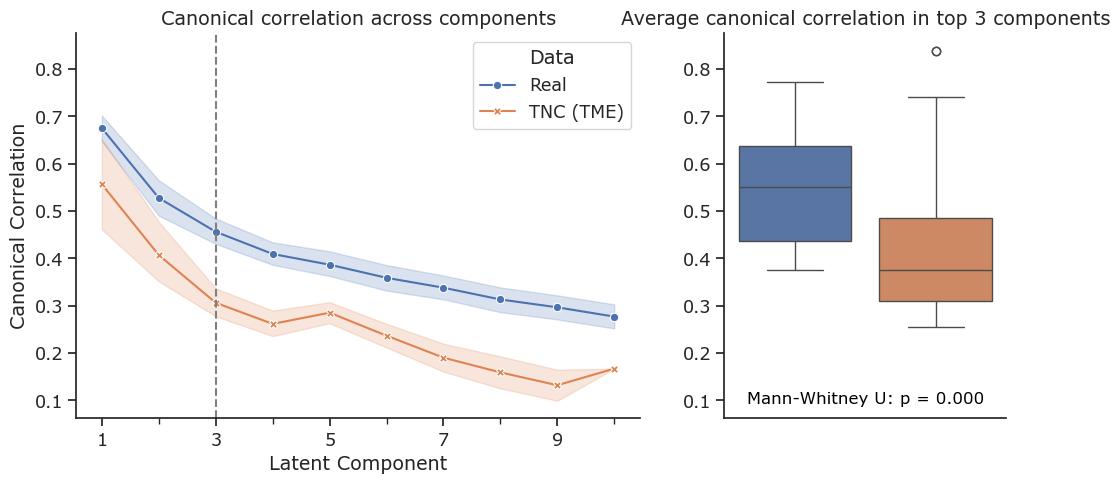

MannwhitneyuResult(statistic=1684.0, pvalue=2.4704116718772917e-06)


In [31]:
hist_comps = 3

sns.set_theme(context='notebook', font='Verdana', font_scale=1.15, style='ticks')
f, axs = plt.subplots(1, 2, figsize=(12,5), sharey=True, width_ratios=[1, 0.5])
# f, axs = plt.subplots(1, 2, figsize=(15,5), sharey=True, width_ratios=[1, 1.25])

sns.lineplot(data=cc_df_long, x='Latent Component', y='Canonical Correlation', hue='Data', style='Data', markers=True, dashes=False, ax=axs[0])
axs[0].axvline(x=hist_comps, color='grey', linestyle='dashed')
axs[0].set_xticks(np.arange(1, 10, 2))
axs[0].xaxis.set_minor_locator(MultipleLocator(2))
axs[0].set_title('Canonical correlation across components')


# sns.histplot(data=cc_df_long[cc_df_long['Neural Mode'] <= 4], y='Canonical Correlation', hue='Data', binwidth=0.15, ax=axs[1])
# sns.histplot(data=cc_df_long[cc_df_long['Component'] <= hist_comps], y='Canonical Correlation', hue='Data', ax=axs[1])
# sns.histplot(data=cc_df_long[(cc_df_long['Latent Component'] <= hist_comps)].groupby(['Data', 'Patient 1', 'Patient 2']).mean().loc[cc_df_long['Data'].unique()], y='Canonical Correlation', hue='Data', ax=axs[1], element='step')
sns.boxplot(data=cc_df_long[cc_df_long['Latent Component'] <= hist_comps], x='Data', y='Canonical Correlation', hue='Data', ax=axs[1])
axs[1].set_title(f'Average canonical correlation in top {hist_comps} components')
axs[1].yaxis.set_tick_params(labelbottom=True)
axs[1].legend([],[], frameon=False)
axs[1].set_xticklabels([])
axs[1].set_xlabel('')
axs[1].set_xticks([])

mwu_res = stats.mannwhitneyu(cc_df_long[(cc_df_long['Data'] == 'Real') & (cc_df_long['Latent Component'] <= hist_comps)]['Canonical Correlation'],
                             cc_df_long[(cc_df_long['Data'] == 'TNC (TME)') & (cc_df_long['Latent Component'] <= hist_comps)]['Canonical Correlation'],
                             alternative='greater', nan_policy='omit')
# annotate p-value on box plot
axs[1].annotate(f'Mann-Whitney U: p = {mwu_res.pvalue:.3f}', xy=(0.5, 0.05), xycoords='axes fraction', ha='center', va='center', fontsize=12, color='black', backgroundcolor='white')

sns.despine()
plt.show()
print(mwu_res)

In [21]:
test_res = stats.mannwhitneyu(cc_df_long[(cc_df_long['Data'] == 'TN (TME)') & (cc_df_long['Latent Component'] <= hist_comps)]['Canonical Correlation'],
                             cc_df_long[(cc_df_long['Data'] == 'TNC (TME)') & (cc_df_long['Latent Component'] <= hist_comps)]['Canonical Correlation'],
                             alternative='greater', nan_policy='omit')
print(test_res)

ValueError: `x` and `y` must be of nonzero size.

In [ ]:
cc_df_long[(cc_df_long['Latent Component'] <= hist_comps)].groupby(['Data', 'Patient 1', 'Patient 2']).mean().loc[cc_df_long['Data'].unique()]

### TSNE with aligned data

In [125]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples

#### Pt-Specific

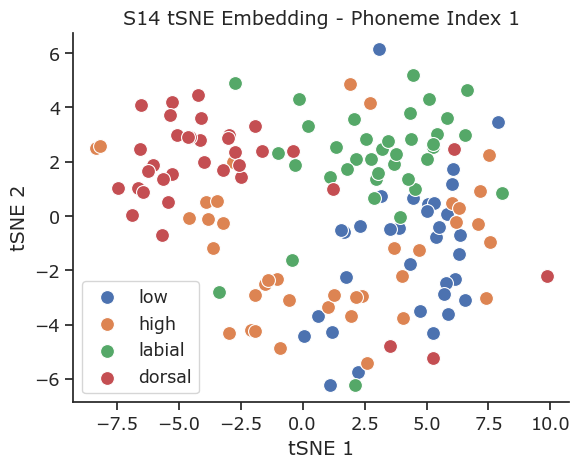

In [262]:
pt = 'S14'
curr_trace = all_pt_traces[pt]
curr_labels = all_pt_artic_labels[pt]
curr_label_names = artic_labels

t_pca_comp = 0.8
pt_time_pca = PCA(n_components=t_pca_comp).fit_transform(curr_trace.reshape(curr_trace.shape[0], -1))
pt_embed_time = TSNE(n_components=2, perplexity=30).fit_transform(pt_time_pca)
# pt_embed_time = TSNE(n_components=2, perplexity=30).fit_transform(curr_trace.reshape(curr_trace.shape[0], -1))

sns.set_theme(context='notebook', font='Verdana', font_scale=1.15, style='ticks')
plt.figure()
for lab in np.unique(curr_labels):
    sns.scatterplot(x=-pt_embed_time[np.where(curr_labels == lab)[0],1], y=-pt_embed_time[np.where(curr_labels == lab)[0],0], s=100)
    # plt.scatter([],[],label=curr_label_names[lab-1])
# sns.scatterplot(x=pt_embed_time[:,0], y=pt_embed_time[:,1], hue=curr_labels, palette='tab10', legend='full')
# plt.scatter(S14_embed_t0[:,0], S14_embed_t0[:,1], c=S14_artic_labels[:,0])
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')
plt.title(f'{pt} tSNE Embedding - Phoneme Index {p_ind}')
plt.legend(labels=curr_label_names)

sns.despine()
plt.show()

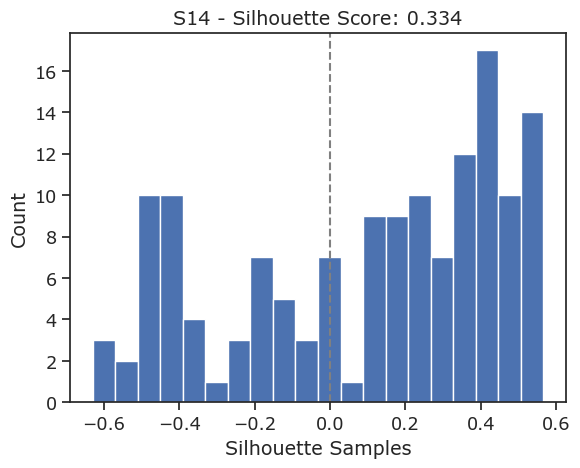

In [263]:
ps_sils = silhouette_samples(pt_embed_time, curr_labels)
ps_sil_score = np.mean(ps_sils[np.where(ps_sils > 0)])
plt.figure()
plt.hist(ps_sils, bins=20)
plt.axvline(0, color='grey', linestyle='dashed')
plt.xlabel('Silhouette Samples')
plt.ylabel('Count')
plt.title(f'{pt} - Silhouette Score: {ps_sil_score:.3f}')
plt.show()

#### Unaligned

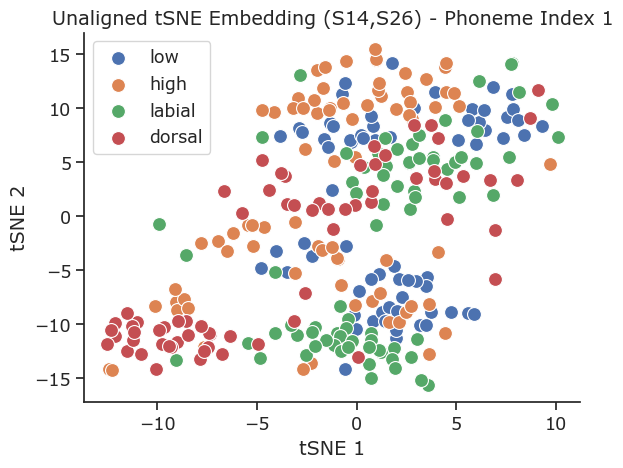

In [260]:
pts = ['S14', 'S26']

curr_unalgn = [PCA(n_components=0.9).fit_transform(all_pt_traces[pt].reshape(-1, all_pt_traces[pt].shape[-1])) for pt in pts]
min_dim = min(u.shape[-1] for u in curr_unalgn)
curr_unalgn = np.vstack([curr_unalgn[i][:,:min_dim].reshape(all_pt_traces[pt].shape[0], all_pt_traces[pt].shape[1], -1) for i,pt in enumerate(pts)])
curr_unalgn_labels = np.hstack([all_pt_artic_labels[pt] for pt in pts])

t_pca_comp = 0.8
unalgn_time_pca = PCA(n_components=t_pca_comp).fit_transform(curr_unalgn.reshape(curr_unalgn.shape[0], -1))
unalgn_embed_time = TSNE(n_components=2, perplexity=30).fit_transform(unalgn_time_pca)

sns.set_theme(context='notebook', font='Verdana', font_scale=1.15, style='ticks')
plt.figure()
for lab in np.unique(curr_unalgn_labels):
    sns.scatterplot(x=-unalgn_embed_time[np.where(curr_unalgn_labels == lab)[0],1], y=-unalgn_embed_time[np.where(curr_unalgn_labels == lab)[0],0], s=100)
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')
plt.title(f'Unaligned tSNE Embedding ({",".join(pts)}) - Phoneme Index {p_ind}')
plt.legend(labels=curr_label_names)

sns.despine()
plt.show()

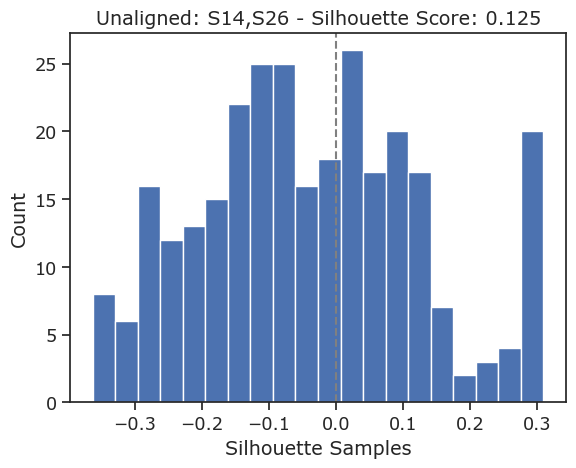

In [261]:
unalgn_sils = silhouette_samples(unalgn_embed_time, curr_unalgn_labels)
unalgn_sil_score = np.mean(unalgn_sils[np.where(unalgn_sils > 0)])
plt.figure()
plt.hist(unalgn_sils, bins=20)
plt.axvline(0, color='grey', linestyle='dashed')
plt.xlabel('Silhouette Samples')
plt.ylabel('Count')
plt.title(f'Unaligned: {",".join(pts)} - Silhouette Score: {unalgn_sil_score:.3f}')
plt.show()

#### CCA-Aligned

In [256]:
pts = ['S14', 'S26']
# aligner = AlignCCA(return_space='shared')
aligner = AlignCCA()
to_align = [PCA(n_components=0.9).fit_transform(all_pt_traces[pt].reshape(-1, all_pt_traces[pt].shape[-1])) for pt in pts]
to_align = [to_align[i].reshape(all_pt_traces[pt].shape[0], all_pt_traces[pt].shape[1], -1) for i, pt in enumerate(pts)]
# [x.shape for x in to_align]
to_align_seqs = [all_pt_phon_seqs[pt] for pt in pts]
aligner.fit(to_align[0], to_align[1], to_align_seqs[0], to_align_seqs[1])
# aligned_data = aligner.transform(to_align)
aligned_pt_data = aligner.transform(to_align[1])
aligned_data = [to_align[0], aligned_pt_data]

In [264]:
curr_algn = np.vstack(aligned_data)
curr_algn_labels = np.hstack([all_pt_artic_labels[pt] for pt in pts])

t_pca_comp = 0.8
algn_time_pca = PCA(n_components=t_pca_comp).fit_transform(curr_algn.reshape(curr_algn.shape[0], -1))
algn_embed_time = TSNE(n_components=2, perplexity=30).fit_transform(algn_time_pca)
# algn_embed_time = TSNE(n_components=2, perplexity=30).fit_transform(curr_algn.reshape(curr_algn.shape[0], -1))

algn_tsne_df = pd.DataFrame(algn_embed_time, columns=['tSNE 1', 'tSNE 2'])
algn_tsne_df['Patient'] = [pts[0]]*all_pt_traces[pts[0]].shape[0] + [pts[1]]*all_pt_traces[pts[1]].shape[0]
algn_tsne_df['Label'] = curr_algn_labels
algn_tsne_df['Label'] = algn_tsne_df['Label'].apply(lambda x: curr_label_names[x-1])

In [1]:


# sns.set_theme(context='notebook', font='Verdana', font_scale=1.15, style='ticks')
# plt.figure()
# for lab in np.unique(curr_algn_labels):
#     sns.scatterplot(x=-algn_embed_time[np.where(curr_algn_labels == lab)[0],1], y=-algn_embed_time[np.where(curr_algn_labels == lab)[0],0], s=100)
# plt.xlabel('tSNE 1')
# plt.ylabel('tSNE 2')
# plt.title(f'Aligned tSNE Embedding ({",".join(pts)}) - Phoneme Index {p_ind}')
# plt.legend(labels=curr_label_names)

# sns.despine()
# plt.show()


sns.set_theme(context='notebook', font='Verdana', font_scale=1.15, style='ticks')
f,ax = plt.subplots(1,1,figsize=(10,7))
# sns.scatterplot(data=algn_tsne_df, x='tSNE 1', y='tSNE 2', hue='Label', style='Patient', markers=True, s=150, ax=ax)
sns.scatterplot(data=algn_tsne_df, x='tSNE 1', y='tSNE 2', hue='Label', markers=True, s=150, ax=ax)
plt.title(f'CCA-Aligned tSNE Embedding ({",".join(pts)}) - Phoneme Index {p_ind}')
sns.despine()
plt.show()

NameError: name 'sns' is not defined

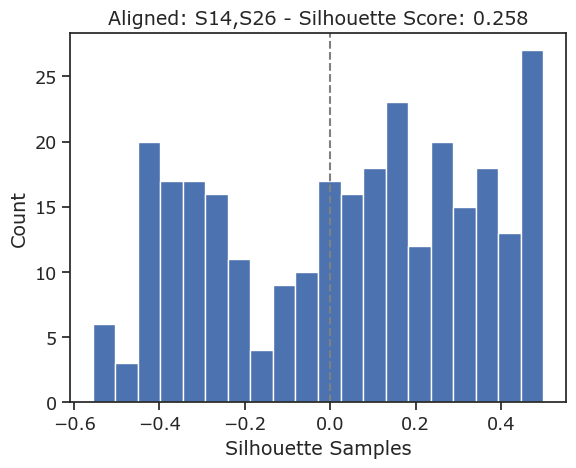

In [266]:
algn_sils = silhouette_samples(algn_embed_time, curr_algn_labels)
algn_sil_score = np.mean(algn_sils[np.where(algn_sils > 0)])
plt.figure()
plt.hist(algn_sils, bins=20)
plt.axvline(0, color='grey', linestyle='dashed')
plt.xlabel('Silhouette Samples')
plt.ylabel('Count')
plt.title(f'Aligned: {",".join(pts)} - Silhouette Score: {algn_sil_score:.3f}')
plt.show()

In [194]:
n_iter = 50
pts = ['S14', 'S26']
unalgn_sil_scores = np.zeros(n_iter)
unalgn_sil_scores_shuf = np.zeros(n_iter)
align_sil_scores = np.zeros(n_iter)
align_sil_scores_shuf = np.zeros(n_iter)
for i in range(n_iter):
    curr_unalgn = [PCA(n_components=0.9).fit_transform(all_pt_traces[pt].reshape(-1, all_pt_traces[pt].shape[-1])) for pt in pts]
    min_dim = min(u.shape[-1] for u in curr_unalgn)
    curr_unalgn = np.vstack([curr_unalgn[i][:,:min_dim].reshape(all_pt_traces[pt].shape[0], all_pt_traces[pt].shape[1], -1) for i,pt in enumerate(pts)])
    curr_unalgn_labels = np.hstack([all_pt_artic_labels[pt] for pt in pts])
    unalgn_time_pca = PCA(n_components=t_pca_comp).fit_transform(curr_unalgn.reshape(curr_unalgn.shape[0], -1))
    unalgn_embed_time = TSNE(n_components=2, perplexity=30).fit_transform(unalgn_time_pca)
    unalgn_sils = silhouette_samples(unalgn_embed_time, curr_unalgn_labels)
    unalgn_sils_shuf = silhouette_samples(unalgn_embed_time, np.random.permutation(curr_unalgn_labels))
    unalgn_score = np.mean(unalgn_sils[np.where(unalgn_sils > 0)])
    unalgn_score_shuf = np.mean(unalgn_sils_shuf[np.where(unalgn_sils_shuf > 0)])
    unalgn_sil_scores[i] = unalgn_score
    unalgn_sil_scores_shuf[i] = unalgn_score_shuf
    
    aligner = AlignCCA()
    to_align = [PCA(n_components=0.9).fit_transform(all_pt_traces[pt].reshape(-1, all_pt_traces[pt].shape[-1])) for pt in pts]
    to_align = [to_align[i].reshape(all_pt_traces[pt].shape[0], all_pt_traces[pt].shape[1], -1) for i, pt in enumerate(pts)]
    # [x.shape for x in to_align]
    to_align_seqs = [all_pt_phon_seqs[pt] for pt in pts]
    aligner.fit(to_align[0], to_align[1], to_align_seqs[0], to_align_seqs[1])
    # aligned_data = aligner.transform(to_align)
    aligned_pt_data = aligner.transform(to_align[1])
    aligned_data = [to_align[0], aligned_pt_data]
    curr_algn = np.vstack(aligned_data)
    curr_algn_labels = np.hstack([all_pt_artic_labels[pt] for pt in pts])
    algn_time_pca = PCA(n_components=t_pca_comp).fit_transform(curr_algn.reshape(curr_algn.shape[0], -1))
    algn_embed_time = TSNE(n_components=2, perplexity=30).fit_transform(algn_time_pca)
    algn_sils = silhouette_samples(algn_embed_time, curr_algn_labels)
    algn_sils_shuf = silhouette_samples(algn_embed_time, np.random.permutation(curr_algn_labels))
    algn_score = np.mean(algn_sils[np.where(algn_sils > 0)])
    algn_score_shuf = np.mean(algn_sils_shuf[np.where(algn_sils_shuf > 0)])
    align_sil_scores[i] = algn_score
    align_sil_scores_shuf[i] = algn_score_shuf


In [195]:
sil_df_real = pd.DataFrame({'Unaligned': unalgn_sil_scores, 'Aligned': align_sil_scores})
sil_df_real_long = sil_df_real.melt(var_name='Data', value_name='Silhouette Score')
sil_df_shuf = pd.DataFrame({'Unaligned': unalgn_sil_scores_shuf, 'Aligned': align_sil_scores_shuf})
sil_df_shuf_long = sil_df_shuf.melt(var_name='Data', value_name='Silhouette Score')
sil_df_real_long['Condition'] = 'Real'
sil_df_shuf_long['Condition'] = 'Shuffled'
sil_df_long = pd.concat([sil_df_real_long, sil_df_shuf_long], ignore_index=True)


In [196]:
fig = px.box(sil_df_long, color='Condition', y="Silhouette Score", x='Data', points='all', width=800, height=500)
# fig.add_hline(y=1/9, line_dash='dash', line_color='grey', annotation_text='Chance', annotation_position='bottom right')
fig.update_layout(
    plot_bgcolor='white',
    legend=dict(
        orientation='h',
        yanchor='top',
        y=0.98,
        xanchor='left',
        x=0.02,
        title_text=''
    ),
    # showlegend=False,
    title_text=f'Clustering with CCA Alignment - {",".join(pts)}',
    title_x=0.5,
    font=dict(size=18, family='Arial')
)
fig.update_xaxes(
    title='',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    # tickvals=[0,1],
    # range=[-0.5, 3.5],
    # ticktext=['Patient-Specific', 'Shared Neural<br>Latent Space'],
)
fig.update_yaxes(
    title='Silhouette Score',
    mirror=False,
    ticks='outside',
    showline=True,
    linecolor='black',
    showgrid=False,
    # range=[0, 0.8]
)
fig.show()

### CCA component investigation

In [267]:
pts = ['S14', 'S26']
aligner = AlignCCA(return_space='shared')
to_align = [PCA(n_components=0.9).fit_transform(all_pt_traces[pt].reshape(-1, all_pt_traces[pt].shape[-1])) for pt in pts]
to_align = [to_align[i].reshape(all_pt_traces[pt].shape[0], all_pt_traces[pt].shape[1], -1) for i, pt in enumerate(pts)]
# [x.shape for x in to_align]
to_align_seqs = [all_pt_phon_seqs[pt] for pt in pts]
aligner.fit(to_align[0], to_align[1], to_align_seqs[0], to_align_seqs[1])
aligned_data = aligner.transform(to_align)

In [271]:
t = np.linspace(-0.5, 0.5 - 1/aligned_data[0].shape[1], aligned_data[0].shape[1])

In [283]:
wide_dfs = []
long_dfs = []
for i, pt in enumerate(pts):
    d = aligned_data[i]
    n_tr = d.shape[0]
    d = d.reshape(-1, d.shape[-1])
    df = pd.DataFrame(d, columns=[f'CC {i+1}' for i in range(d.shape[-1])])
    df['Time'] = np.tile(t, n_tr)
    df['Patient'] = [pt] * d.shape[0]
    df['Phoneme IDs'] = np.repeat(all_pt_phon_seqs_str[pt], t.shape[0])
    df['Vowel Sequence'] = df['Phoneme IDs'].apply(labels2cv)
    df['Phoneme Sequence'] = df['Phoneme IDs'].apply(lambda x: ''.join([phon_labels[int(i)-1] for i in x]))
    df['Articulator Sequence'] = df['Phoneme IDs'].apply(phon2artic_seq)
    # cols = df.columns.tolist()
    # cols = cols[-3:] + cols[:-3]
    # df = df[cols]
    wide_dfs.append(df)
    df = df.melt(id_vars=['Time', 'Patient', 'Phoneme IDs', 'Vowel Sequence', 'Phoneme Sequence', 'Articulator Sequence'], var_name='CC', value_name='Value')
    df['CC'] = df['CC'].apply(lambda x: int(x.split(' ')[-1]))
    # df['PC'] = df['PC'] + 1
    # df = df[['Patient', 'Phoneme IDs', 'Time', 'PC', 'Value']]
    long_dfs.append(df)
algn_wide_df = pd.concat(wide_dfs)
algn_long_df = pd.concat(long_dfs)

In [285]:
algn_long_df

,Time,Patient,Phoneme IDs,Vowel Sequence,Phoneme Sequence,Articulator Sequence,CC,Value
0,-0.500,S14,915,CVC,kab,dorsal_low_labial,1,-0.011810
1,-0.495,S14,915,CVC,kab,dorsal_low_labial,1,-0.011327
2,-0.490,S14,915,CVC,kab,dorsal_low_labial,1,-0.010994
3,-0.485,S14,915,CVC,kab,dorsal_low_labial,1,-0.010892
4,-0.480,S14,915,CVC,kab,dorsal_low_labial,1,-0.010777
...,...,...,...,...,...,...,...,...
739995,0.475,S26,152,VCV,abae,low_labial_low,25,-0.008787
739996,0.480,S26,152,VCV,abae,low_labial_low,25,-0.010515
739997,0.485,S26,152,VCV,abae,low_labial_low,25,-0.011291
739998,0.490,S26,152,VCV,abae,low_labial_low,25,-0.011332


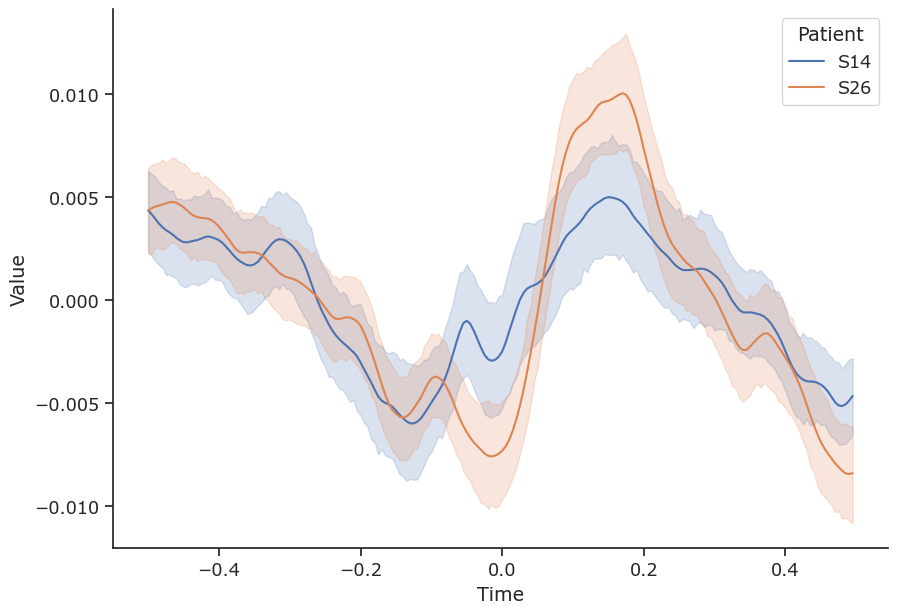

In [295]:
sns.set_theme(context='notebook', font='Verdana', font_scale=1.15, style='ticks')
f,ax = plt.subplots(1,1,figsize=(10,7))
sns.lineplot(data=algn_long_df[algn_long_df['CC'] == 5], x='Time', y='Value', hue='Patient', markers=False, dashes=False, ax=ax)
sns.despine()
plt.show()

### (M)CCA Maps

In [52]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def chan_disp(data, chan_map, title, label, figsize=(8, 6)):
    chan_data = np.array([data[int(i)] if not np.isnan(i) else np.nan for i in (chan_map.flatten()-1)])
    chan_data = chan_data.reshape(chan_map.shape)
    f = plt.figure(figsize=figsize)
    im = plt.imshow(chan_data)
    # plt.gca().invert_yaxis()
    # plt.contourf(chan_data, cmap='viridis')
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes('right', size='5%', pad=0.05)

    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label(label)
    
    plt.show()

#### MCCA fitting

In [68]:
from alignment.alignment_utils import extract_group_conditions
from alignment.AlignMCCA import n_components_var
from mvlearn.embed import MCCA

In [69]:
all_pt_data = [all_pt_traces[pt] for pt in pt_names]
all_pt_pseqs = [all_pt_phon_seqs[pt] for pt in pt_names]

In [101]:
n_comp = 25
pca_var = 0.9
ranks = [n_components_var(x.reshape(-1, x.shape[-1]), pca_var) for x in all_pt_data]

cnd_avg_data = extract_group_conditions(all_pt_data, all_pt_pseqs)
cnd_avg_data = [d.reshape(-1, d.shape[-1]) for d in cnd_avg_data]

mcca = MCCA(n_components=n_comp, regs=0.5, signal_ranks=ranks)
mcca_scores = mcca.fit_transform(cnd_avg_data)

In [102]:
mcca_corrs = mcca.canon_corrs(mcca_scores)
print(mcca_corrs.shape)
# print(mcca_corrs)

# average across non diagonal elements in correlation matrices
weights = (mcca_corrs != 1).astype(int)
pt_corrs = np.average(mcca_corrs, weights=weights, axis=1).T
print(pt_corrs.shape)

(25, 8, 8)
(8, 25)


In [103]:
pt_mcca_elecs = {}
for i, (corrs, pt) in enumerate(zip(pt_corrs, pt_names)):
    # print(i, pt)
    pt_loading = mcca.loadings_[i]
    loading_inv = np.linalg.pinv(pt_loading)
    corr_elecs = np.dot(corrs, loading_inv)
    pt_mcca_elecs[pt] = np.full(np.prod(all_pt_chan_data[pt]['map'].shape), np.nan)
    pt_mcca_elecs[pt][all_pt_chan_data[pt]['sig'].flatten()] = corr_elecs
    print(pt_mcca_elecs[pt].shape)

(128,)
(128,)
(128,)
(288,)
(128,)
(288,)
(288,)
(288,)


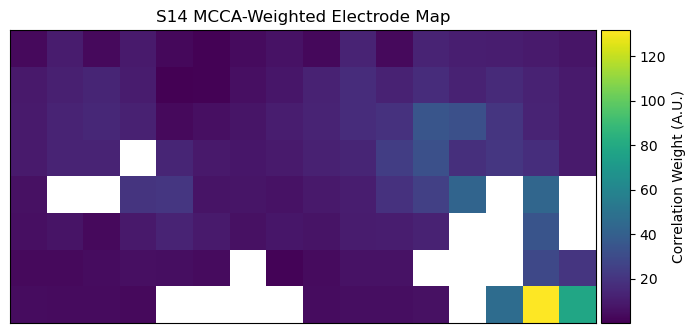

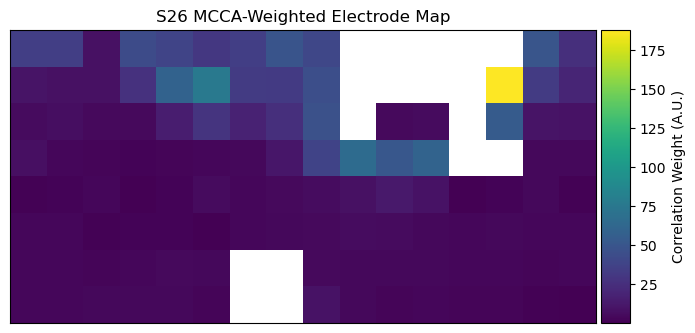

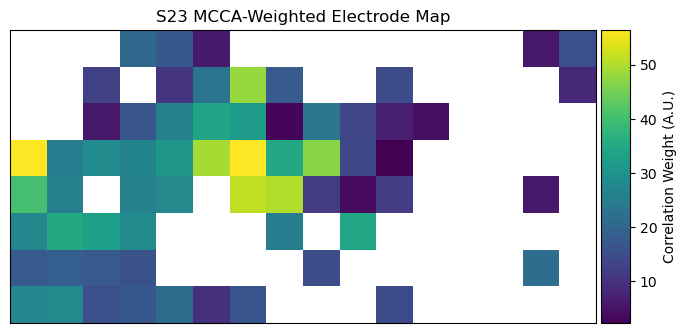

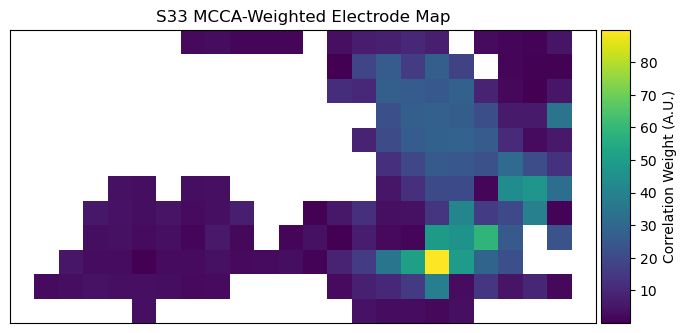

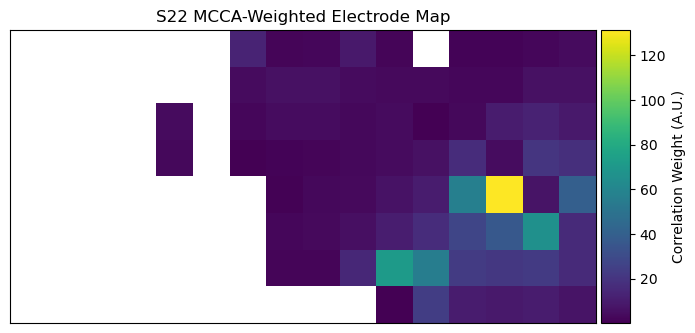

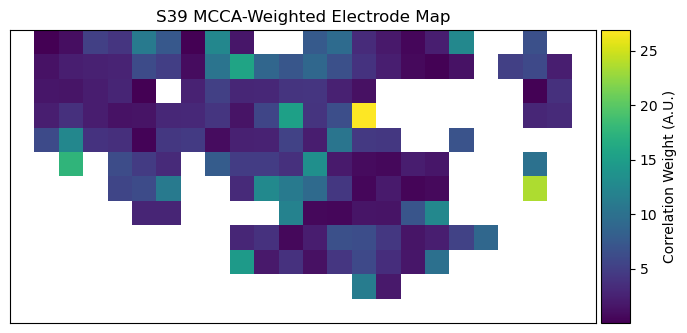

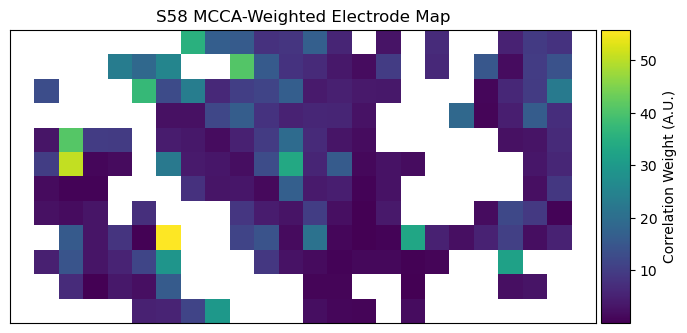

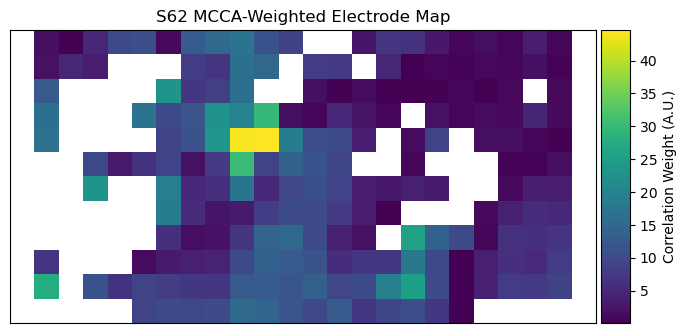

In [105]:
for pt, elecs in pt_mcca_elecs.items():
    chan_disp(np.abs(elecs), np.flipud(all_pt_chan_data[pt]['map']), f'{pt} MCCA-Weighted Electrode Map', 'Correlation Weight (A.U.)', figsize=(8,6))

In [116]:
sig_mcca_elecs = 0
sig_total_elecs = 0
for pt, elecs in pt_mcca_elecs.items():
    # count number of electrodes with correlation weights above 10th percentile
    sig_mcca_elecs += np.sum(elecs > np.nanpercentile(elecs, 10))
    # print(np.nanmean(elecs), np.nanpercentile(elecs, 10))
    sig_total_elecs += elecs.shape[0]
print(f'{sig_mcca_elecs} significant aligned electrodes out of {sig_total_elecs} total electrodes ({sig_mcca_elecs/sig_total_elecs:.2f})')

916 significant aligned electrodes out of 1664 total electrodes (0.55)


## PCA Channel Permutation Analysis

In [17]:
from sklearn.decomposition import PCA

from alignment.AlignCCA import CCA_align, extract_latent_dynamics_by_class

In [23]:
n_comp_pca = 0.9
n_comp_cca = 10
n_repeats = 100
n_comp_corr = 3

In [24]:
S14_data, S14_labels = all_pt_traces['S14'], all_pt_phon_seqs_str['S14']
S26_data, S26_labels = all_pt_traces['S26'], all_pt_phon_seqs_str['S26']

In [39]:
PCA_S14 = PCA(n_components=n_comp_pca)
PCA_S26 = PCA(n_components=n_comp_pca)

S14_data_cnd_avg = utils.cnd_avg(S14_data, S14_labels)
S26_data_cnd_avg = utils.cnd_avg(S26_data, S26_labels)

# decmopose channels (trial*time, channels)
# S14_2d = S14_data_cnd_avg.reshape(-1, S14_data.shape[-1])
# S26_2d = S26_data_cnd_avg.reshape(-1, S26_data.shape[-1])

# decompose time (trial*channel, time)
S14_2d = S14_data_cnd_avg.transpose(0,2,1).reshape(-1, S14_data.shape[1])
S26_2d = S26_data_cnd_avg.transpose(0,2,1).reshape(-1, S26_data.shape[1])

latDyn_S14 = PCA_S14.fit_transform(S14_2d)
latDyn_S26 = PCA_S26.fit_transform(S26_2d)

S14_decomp_matrix = PCA_S14.components_

In [40]:
_,_,CCs_S14_S26 = CCA_align(latDyn_S14.T, latDyn_S26.T)
CCs_S14_S26 = CCs_S14_S26[:n_comp_cca]
corr_S14_S26 = np.mean(CCs_S14_S26[:n_comp_corr])

Permute decomposition vectors

In [42]:
null_corrs = []
for i in range(n_repeats):
    S14_decomp_perm = np.zeros(S14_decomp_matrix.shape)
    for i in range(S14_decomp_matrix.shape[0]):
        perm_inds = np.random.permutation(S14_decomp_matrix.shape[1])
        S14_decomp_perm[i] = S14_decomp_matrix[i, perm_inds]
    
    # latDyn_S14_perm = np.dot(S14_data_cnd_avg.reshape(-1, S14_data.shape[-1]), S14_decomp_perm.T)
    latDyn_S14_perm = np.dot(S14_data_cnd_avg.transpose(0,2,1).reshape(-1, S14_data.shape[1]), S14_decomp_perm.T)    
        
    _,_,CCs_S14_S26_perm = CCA_align(latDyn_S14_perm.T, latDyn_S26.T)
    CCs_S14_S26_perm = CCs_S14_S26_perm[:n_comp_cca]
    
    avg_corrs = np.mean(CCs_S14_S26_perm[:n_comp_corr])
    null_corrs.append(avg_corrs)
    

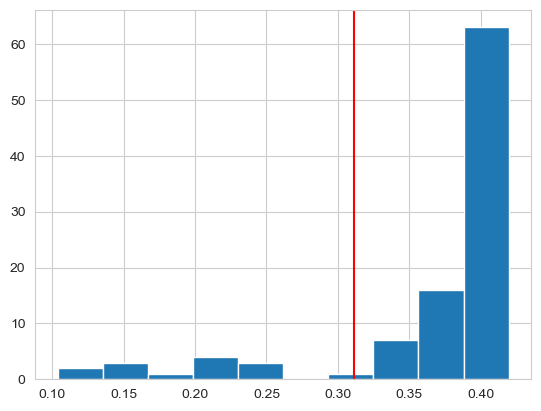

In [43]:
plt.figure()
plt.hist(null_corrs)
plt.axvline(corr_S14_S26, color='r')
plt.show()

In [44]:
from scipy.stats import ttest_1samp

res = ttest_1samp(null_corrs, corr_S14_S26, alternative='less')
print(res)

TtestResult(statistic=7.207273493240934, pvalue=0.99999999994269, df=99)


In [45]:
res.pvalue

0.99999999994269